In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
import tensorflow as tf
from error_propagation_radon_transform import utils
import ipywidgets as widgets

In [17]:
def sliceRSP(rsp, z=0, scale=1):
    phantom = np.pad(rsp[:,:,z], ((30*scale,30*scale), (100*scale, 100*scale)))
    RSP_shape = phantom.shape[:2]
    return phantom, RSP_shape

def calcWEPL(RSP, MLP):
    wepl = MLP @ RSP.flatten()
    return wepl

def createStd(wepl, num_spotx):
    upper_edge = (wepl > 1e-2).argmax(axis=0)
    lower_edge = wepl.shape[0] - np.flip(wepl > 1e-2, 0).argmax(axis=0)

    std = np.zeros_like(wepl)
    for i in range(std.shape[1]):
        x_observed = [upper_edge[i] - num_spotx//2, upper_edge[i] + 2 - num_spotx//2, 0, lower_edge[i] - 2 - num_spotx//2, lower_edge[i] - num_spotx//2 ]

        y_observed = np.array([ 5, 3.8, 2.05, 3.8, 5 ])
        coeff = np.polyfit(x_observed, y_observed, 6)

        x = np.linspace(-num_spotx//2, num_spotx//2, num_spotx)
        polynom = np.poly1d(coeff)

        y = polynom(x)

        y[:upper_edge[i]] = 0
        y[lower_edge[i]:] = 0

        std[:,i] = y

    return std

def exponential(value, gamma):
    return np.exp( - gamma * value)

In [3]:
num_angle=90
num_offset=1
num_spotx=130
chord_length=True
filter_name='ramp'

In [4]:
rsp = np.load('../../Data/simple_pCT/Phantoms/Head/RSP.npy')
_, RSP_shape = sliceRSP(rsp, 0)

width = 10
chords = 'exact' if chord_length else 'map'

In [7]:
MLP_angles_offsets_spotx = sparse.load_npz('../../Data/simple_pCT/MLP/MLP_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npz'.format(num_angle, num_offset, num_spotx, RSP_shape[0], RSP_shape[1]))

jacobian = np.load('../../Data/simple_pCT/Jacobian/J_angles{:d}_offset{:d}_spotx{:d}_{:s}_{:s}_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, chords, filter_name, RSP_shape[0], RSP_shape[1]))
l,m,n,o = jacobian.shape
jacobian_reshaped = tf.reshape(jacobian, (l*m, n*o))

2024-06-20 09:26:15.211781: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-20 09:26:15.212419: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-20 09:26:15.212439: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-20 09:26:15.212463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (head2): /proc/driver/nvidia/version does not exist
2024-06-20 09:26:15.214998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

In [12]:
z = 512

x, _ = sliceRSP(rsp, z)

wepl = calcWEPL(x, MLP_angles_offsets_spotx)
wepl = np.reshape(wepl, (num_spotx, num_angle))

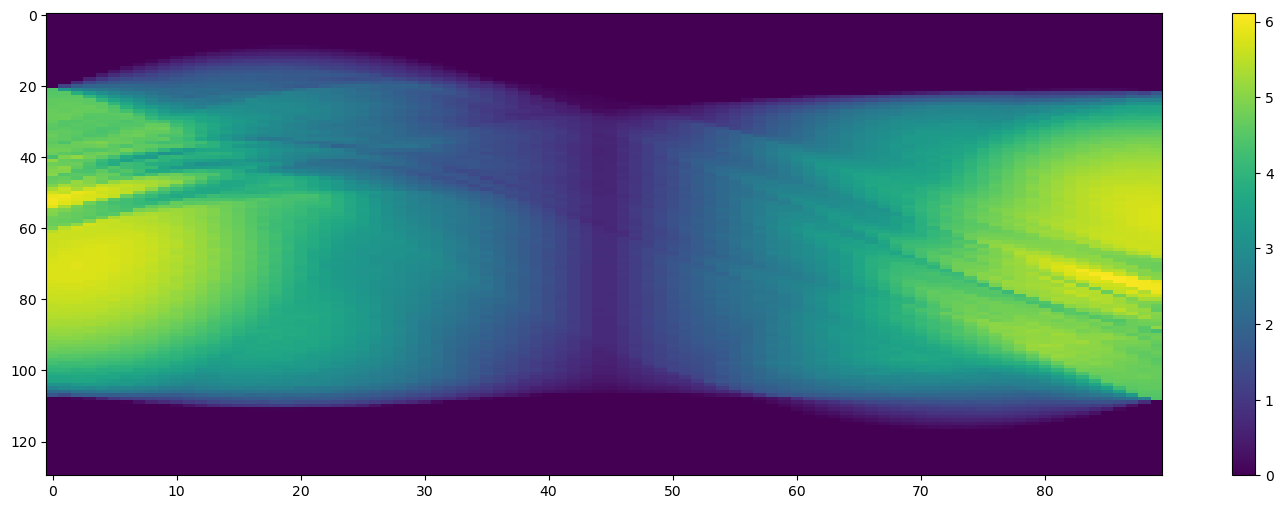

In [13]:
plt.figure(figsize=(18,6))
plt.imshow(wepl, aspect='auto')
plt.colorbar()
plt.show()

In [14]:
std = createStd(wepl, num_spotx)

/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: RankWarning: Polyfit may be poorly conditioned
  std = createStd(wepl, num_spotx)
/tmp/ipykernel_59651/1118287419.py:1: Ra

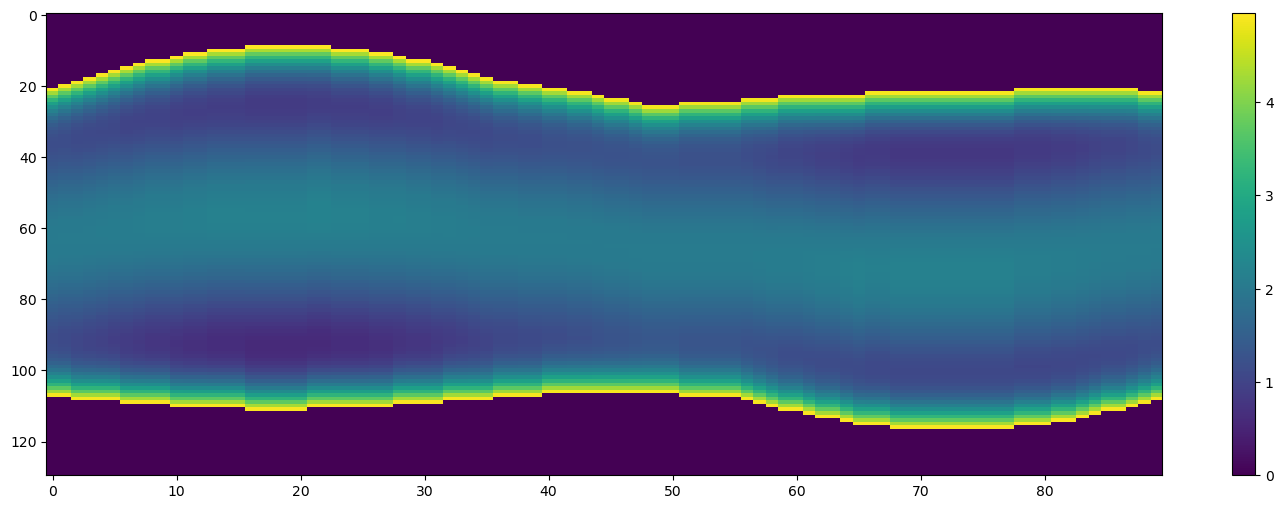

In [15]:
plt.figure(figsize=(18,6))
plt.imshow(std, aspect='auto')
plt.colorbar()
plt.show()

In [18]:
Sigma_in = utils.build_covariance_y(std**2, function=exponential, width=width)

In [26]:
vmin = Sigma_in.min()
vmax = Sigma_in.max()

@widgets.interact(phi=(0,std.shape[0]-1,1), t=(0,std.shape[1]-1,1))
def show_Sigma(phi=0, t=0):
    idx = np.ravel_multi_index([t, phi], std.shape)

    plt.figure(figsize=(18,6))
    plt.imshow(Sigma_in[:,idx].reshape(std.shape), aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='phi', max=129), IntSlider(value=0, description='t', max=…

In [27]:
Sigma_out = jacobian_reshaped @ Sigma_in @ np.transpose(jacobian_reshaped)

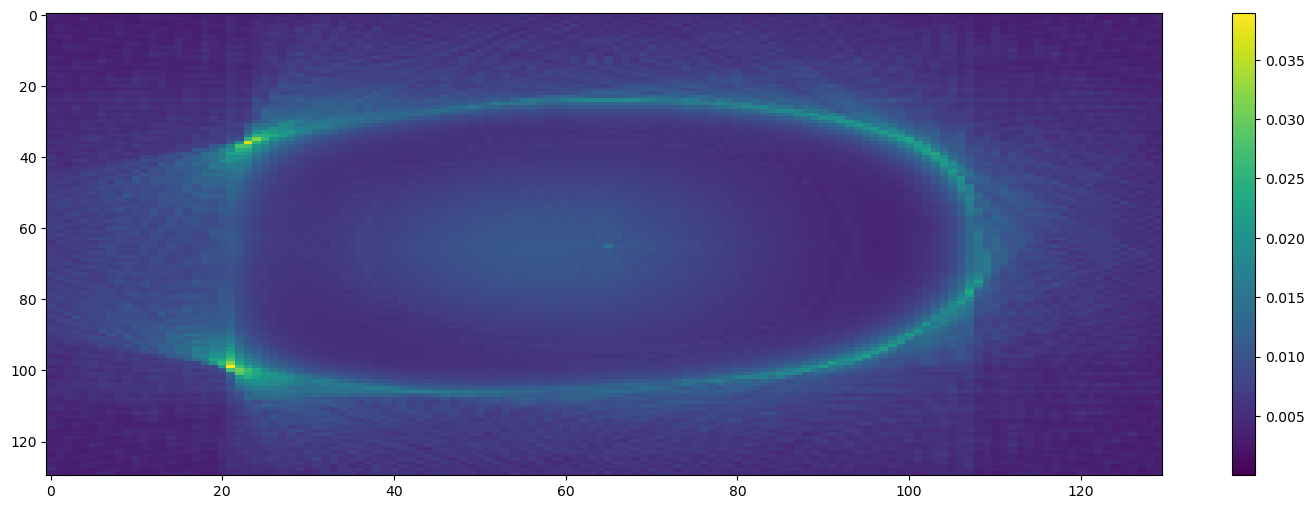

In [35]:
variance = tf.reshape(tf.abs(tf.linalg.tensor_diag_part(Sigma_out)), (num_spotx,num_spotx))

plt.figure(figsize=(18,6))
plt.imshow(variance, aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [34]:
vmin = tf.reduce_min(tf.abs(Sigma_out))
vmax = tf.reduce_max(tf.abs(Sigma_out))

@widgets.interact(x=(0,num_spotx-1,1), y=(0,num_spotx-1,1))
def show_Sigma(x=0, y=0):
    idx = np.ravel_multi_index([x, y], [num_spotx, num_spotx])

    plt.figure(figsize=(18,6))
    plt.imshow(tf.reshape(tf.abs(Sigma_out[:,idx]), [num_spotx, num_spotx]), aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=129), IntSlider(value=0, description='y', max=12…